# TPS 02: Tree Ensembles

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 8
NUM_TREES = 300

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import re
import math
import os
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
import optuna
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image


# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Helper Functions

In [3]:
# Helper functions from https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product

def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return bias(w, x, y, z)

def get_histograms(input_df):
    return pd.DataFrame({
        col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
    })

def gcd_of_all(df_i):
    gcd = df_i[features[0]]
    for col in features[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

def get_target_bins():
    temp = train[['target','target']].copy()
    temp.columns = ['row_id','target']
    temp['row_id'] = gcd_of_all(get_histograms(train[features]))
    return temp['row_id'].astype(str) + temp['target'].astype(str)


def remove_duplicates(input_df):
    # Create a new dataframe without duplicates, but with an additional sample_weight column
    vc = input_df[features + ['target']].value_counts()
    dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns = input_df[features + ['target']].columns)
    dedup_train['sample_weight'] = vc.values
    return dedup_train

# Scoring Function

In [25]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, get_target_bins())):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx].to_numpy(), train['target'].iloc[train_idx].to_numpy()
        X_valid, y_valid = train[features].iloc[valid_idx].to_numpy(), train['target'].iloc[valid_idx].to_numpy()
        
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        model.fit(
            X_train, y_train, 
            sample_weight = train['sample_weight'].iloc[train_idx]
        )

        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds.flatten()
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
        
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    return oof_preds
    

# Confusion Matrix

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [6]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id', 'target']]

# Label encoding
encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])
train = remove_duplicates(train)
train_gcds = gcd_of_all(get_histograms(train[features]))

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 1min 2s
Wall time: 1min 30s


# Sklearn Tree Ensembles

In [7]:
# Base Estimators
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

## 1. AdaBoost

In [8]:
from sklearn.ensemble import AdaBoostClassifier


Fold 0: 0.89652 accuracy in 39.77s.
Fold 1: 0.89928 accuracy in 38.13s.
Fold 2: 0.90341 accuracy in 34.9s.
Fold 3: 0.90045 accuracy in 35.91s.
Fold 4: 0.89509 accuracy in 42.8s.
Fold 5: 0.89922 accuracy in 33.08s.
Fold 6: 0.90238 accuracy in 19.67s.
Fold 7: 0.89896 accuracy in 16.94s.

Average Accuracy: 0.89941
Training Time: 261.19s


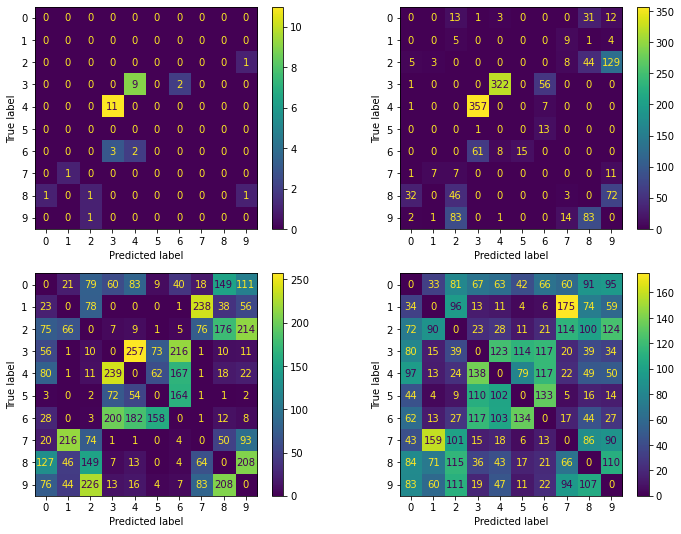

In [9]:
# Base Estimator - Default DecisionTree
oof_preds = score_model(
    AdaBoostClassifier(
        DecisionTreeClassifier(),
        n_estimators = NUM_TREES,
    )
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

## 2. Bagging Classifier

In [10]:
from sklearn.ensemble import BaggingClassifier


Fold 0: 0.93626 accuracy in 21.29s.
Fold 1: 0.93748 accuracy in 19.58s.
Fold 2: 0.94174 accuracy in 20.13s.
Fold 3: 0.93993 accuracy in 18.98s.
Fold 4: 0.93838 accuracy in 19.1s.
Fold 5: 0.93871 accuracy in 19.68s.
Fold 6: 0.938 accuracy in 19.48s.
Fold 7: 0.94116 accuracy in 19.1s.

Average Accuracy: 0.93896
Training Time: 157.33s


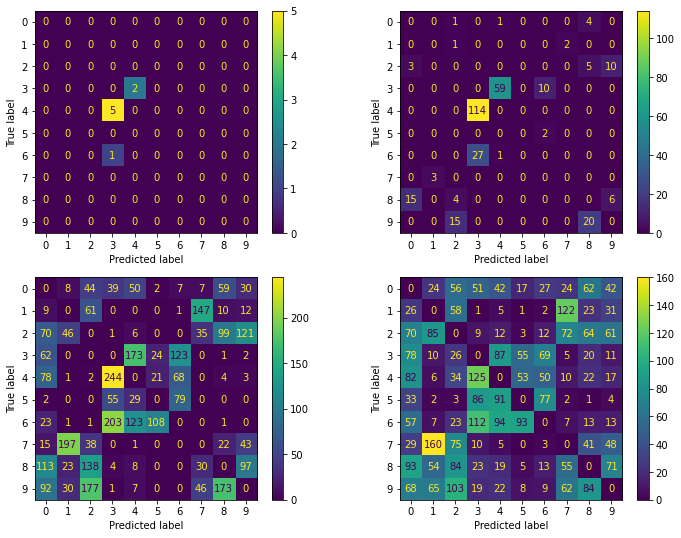

In [11]:
oof_preds = score_model(
    BaggingClassifier(
        random_state = RANDOM_SEED,
        n_jobs = -1
    )
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

## 3. Extra Trees

In [12]:
from sklearn.ensemble import ExtraTreesClassifier


Fold 0: 0.97548 accuracy in 21.43s.
Fold 1: 0.97471 accuracy in 21.76s.
Fold 2: 0.97477 accuracy in 21.44s.
Fold 3: 0.97671 accuracy in 21.6s.
Fold 4: 0.97561 accuracy in 21.49s.
Fold 5: 0.97503 accuracy in 21.49s.
Fold 6: 0.974 accuracy in 21.38s.
Fold 7: 0.9751 accuracy in 21.36s.

Average Accuracy: 0.97518
Training Time: 171.94s


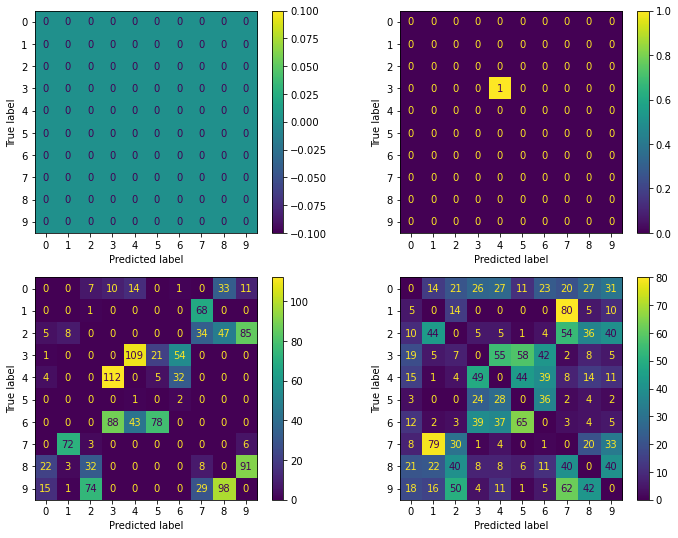

In [13]:
oof_preds = score_model(
    ExtraTreesClassifier(
        n_jobs = -1, 
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

## 4. Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier


Fold 0: 0.97348 accuracy in 21.68s.
Fold 1: 0.97245 accuracy in 21.64s.
Fold 2: 0.97245 accuracy in 21.83s.
Fold 3: 0.97168 accuracy in 21.72s.
Fold 4: 0.97251 accuracy in 22.01s.
Fold 5: 0.97393 accuracy in 21.98s.
Fold 6: 0.97245 accuracy in 21.56s.
Fold 7: 0.97239 accuracy in 21.75s.

Average Accuracy: 0.97267
Training Time: 174.17s


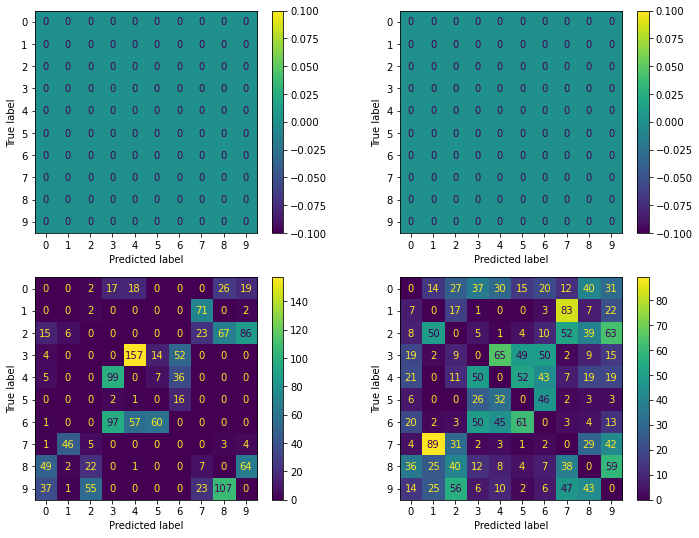

In [15]:
oof_preds = score_model(
    RandomForestClassifier(
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
        n_jobs = -1,
    )
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

## 5. Gradient Boosting

In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier


Fold 0: 0.97548 accuracy in 249.79s.
Fold 1: 0.97303 accuracy in 250.79s.
Fold 2: 0.97387 accuracy in 250.64s.
Fold 3: 0.9758 accuracy in 250.02s.
Fold 4: 0.97368 accuracy in 250.55s.
Fold 5: 0.97535 accuracy in 251.4s.
Fold 6: 0.9729 accuracy in 250.92s.
Fold 7: 0.97484 accuracy in 250.97s.

Average Accuracy: 0.97437
Training Time: 2005.07s


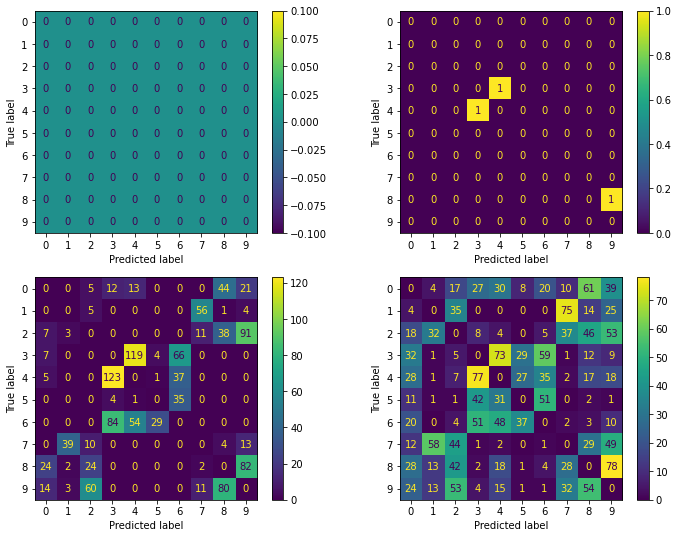

In [17]:
oof_preds = score_model(
    HistGradientBoostingClassifier(        
        max_iter = NUM_TREES,
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

# XGBoost

In [18]:
from xgboost import XGBClassifier


Fold 0: 0.97587 accuracy in 405.0s.
Fold 1: 0.97426 accuracy in 406.1s.
Fold 2: 0.97484 accuracy in 412.65s.
Fold 3: 0.97451 accuracy in 420.11s.
Fold 4: 0.97471 accuracy in 418.55s.
Fold 5: 0.97561 accuracy in 417.81s.
Fold 6: 0.9738 accuracy in 404.75s.
Fold 7: 0.97497 accuracy in 405.14s.

Average Accuracy: 0.97482
Training Time: 3290.11s


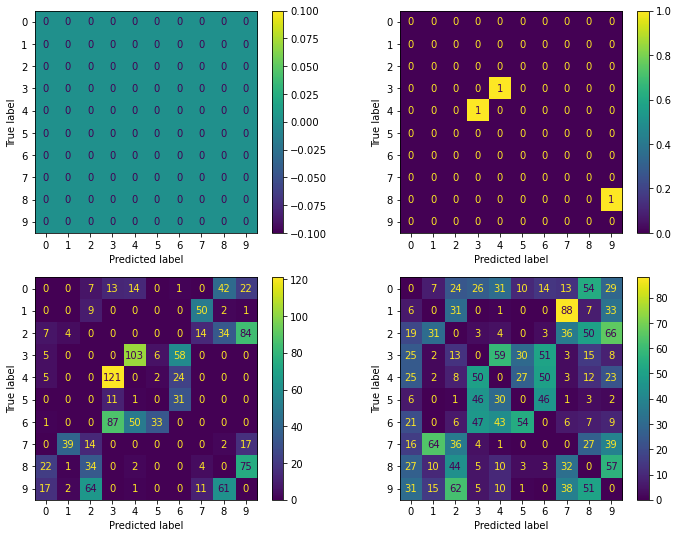

In [19]:
oof_preds = score_model(
    XGBClassifier(
        eval_metric = 'mlogloss',
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
        n_jobs = -1,
    )
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

# LightGBM

In [20]:
from lightgbm import LGBMClassifier


Fold 0: 0.97755 accuracy in 65.93s.
Fold 1: 0.9758 accuracy in 65.06s.
Fold 2: 0.97645 accuracy in 64.64s.
Fold 3: 0.97716 accuracy in 63.15s.
Fold 4: 0.97522 accuracy in 63.0s.
Fold 5: 0.97593 accuracy in 63.73s.
Fold 6: 0.97484 accuracy in 63.47s.
Fold 7: 0.97471 accuracy in 63.33s.

Average Accuracy: 0.97596
Training Time: 512.29s


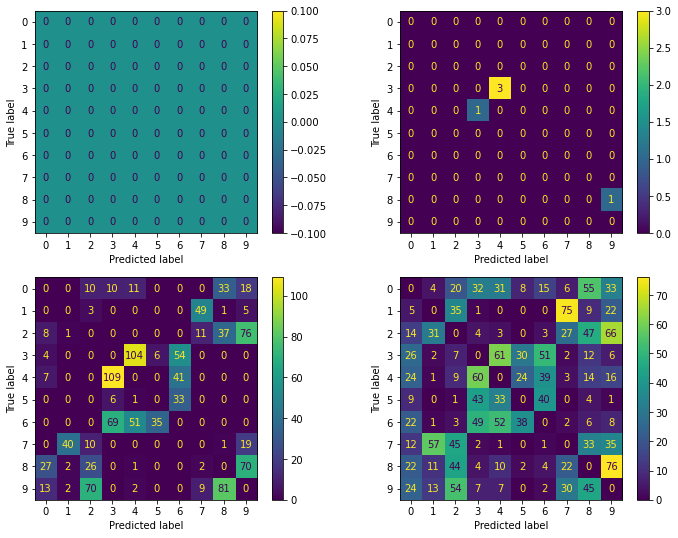

In [21]:
oof_preds = score_model(
    LGBMClassifier(       
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
    )
)

plot_confusion_matrix(train['target'], oof_preds, train_gcds)

# CatBoost

In [22]:
from catboost import CatBoostClassifier


Fold 0: 0.95606 accuracy in 229.89s.
Fold 1: 0.95567 accuracy in 231.98s.
Fold 2: 0.95606 accuracy in 238.16s.
Fold 3: 0.95806 accuracy in 238.88s.
Fold 4: 0.95496 accuracy in 240.2s.
Fold 5: 0.95477 accuracy in 243.25s.
Fold 6: 0.95626 accuracy in 236.53s.
Fold 7: 0.95671 accuracy in 232.07s.

Average Accuracy: 0.95607
Training Time: 1890.97s


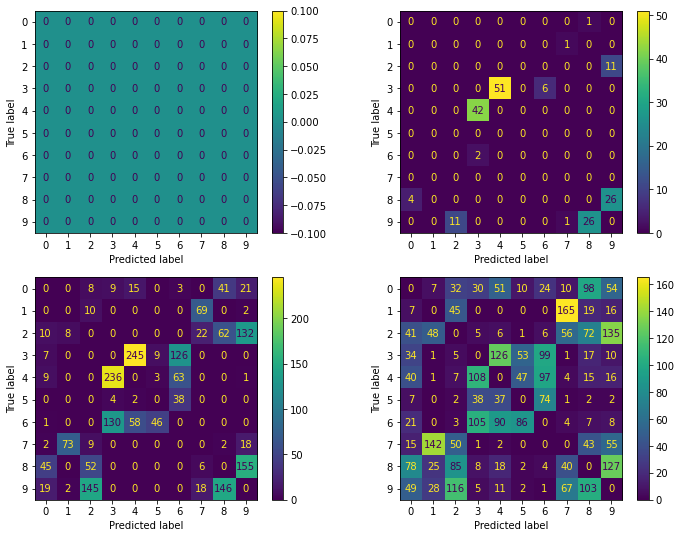

In [26]:
oof_preds = score_model(
    CatBoostClassifier(        
        n_estimators = NUM_TREES,
        random_state = RANDOM_SEED,
        verbose = False
    )
)

plot_confusion_matrix(train['target'], oof_preds, train_gcds)